In [21]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers,regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  CSVLogger, EarlyStopping, LearningRateScheduler

In [98]:
!nvidia-smi

Fri Jun 23 09:40:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    29W /  70W |   6923MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
import os
os.getcwd()

'/content'

In [24]:
#Configuration
csv_path = os.path.join("/content/drive/MyDrive/Transfer files (Clear it frequently)/model", "potatoes-model_log3.csv")
#shall be changed after every model training
batch_size = 32
image_width = 256
image_height = 256
channels = 3

In [25]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory= "/content/po",
    batch_size= batch_size,
    image_size= (image_width,image_height)
    )

Found 2144 files belonging to 3 classes.


In [26]:
class_names = dataset.class_names

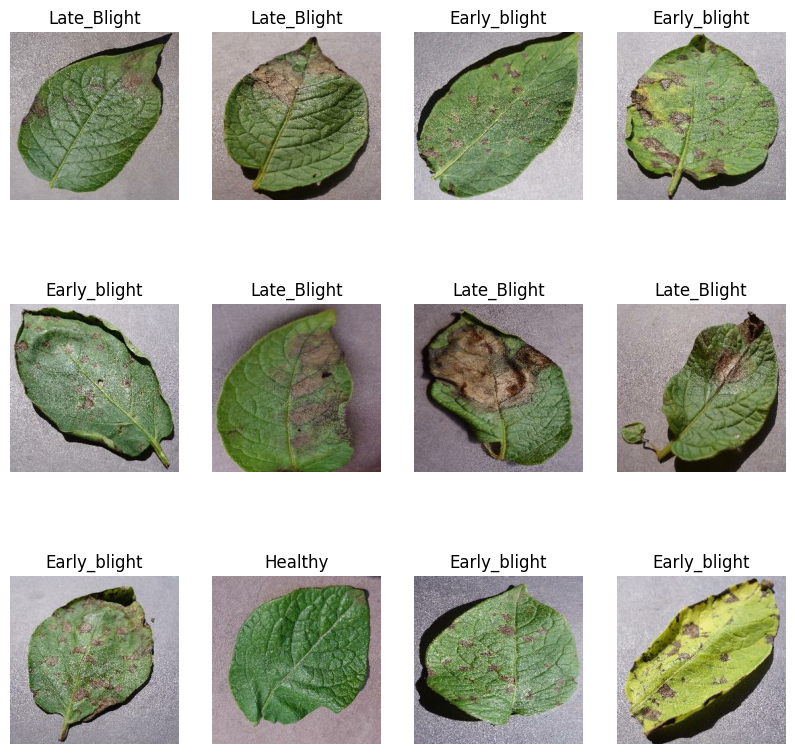

In [27]:
plt.figure(figsize=(10,10))

for image,image_label in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[image_label[i].numpy()])
    plt.axis('off')


In [28]:
def split_dataset (dataset, train_split = 0.8, test_split = 0.1, validation_split = 0.1, shuffel = True, seed_value = 45, shuffel_value = 10000):
  dataset_size = len(dataset)

  train_size = int(dataset_size*train_split)
  validation_size = int(validation_split*dataset_size)

  if shuffel:
    dataset = dataset.shuffle(shuffel_value, seed = seed_value)
  train_data = dataset.take(train_size)
  test_data = dataset.skip(train_size).take(validation_size)
  validation_data  = dataset.skip(train_size).skip(validation_size)


  return train_data, test_data, validation_data

In [29]:
train_data, test_data, validation_data = split_dataset(dataset)

In [30]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_data = validation_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(image_height,image_width),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [32]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
input_shape = (batch_size, image_height, image_width, channels)
n_classes = 3
L2_lr = 0.01
optimizer_lr = 0.001

In [34]:
# Define the learning rate schedule function
def lr_schedule(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.00001

# Create the Adam optimizer
optimizer = Adam()

In [35]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu',kernel_regularizer=regularizers.l2(L2_lr), input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',kernel_regularizer=regularizers.l2(L2_lr)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',kernel_regularizer=regularizers.l2(L2_lr)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(L2_lr)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(L2_lr)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(L2_lr)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(L2_lr)),
    layers.Dense(n_classes, activation='softmax')])

model.build(input_shape=input_shape)

In [36]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [38]:
callbacks = [
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=False),
        LearningRateScheduler(lr_schedule)]

In [39]:
history = model.fit(
    train_data,
    batch_size=batch_size,
    validation_data=validation_data,
    verbose=1,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
53/53 [==============================] - 24s 350ms/step - loss: 4.7217 - accuracy: 0.4811 - val_loss: 4.3506 - val_accuracy: 0.5586 - lr: 1.0000e-04
Epoch 2/50
53/53 [==============================] - 18s 329ms/step - loss: 4.0537 - accuracy: 0.5271 - val_loss: 3.8083 - val_accuracy: 0.4609 - lr: 1.0000e-04
Epoch 3/50
53/53 [==============================] - 17s 321ms/step - loss: 3.5619 - accuracy: 0.5884 - val_loss: 3.3469 - val_accuracy: 0.6836 - lr: 1.0000e-04
Epoch 4/50
53/53 [==============================] - 17s 312ms/step - loss: 3.1102 - accuracy: 0.6952 - val_loss: 2.8824 - val_accuracy: 0.7461 - lr: 1.0000e-04
Epoch 5/50
53/53 [==============================] - 17s 314ms/step - loss: 2.6645 - accuracy: 0.7459 - val_loss: 2.4913 - val_accuracy: 0.7617 - lr: 1.0000e-04
Epoch 6/50
53/53 [==============================] - 16s 307ms/step - loss: 2.3436 - accuracy: 0.7765 - val_loss: 2.2010 - val_accuracy: 0.8008 - lr: 1.0000e-04
Epoch 7/50
53/53 [======================

In [45]:
scores = model.evaluate(test_data)

6/6 [==============================] - 0s 29ms/step - loss: 1.1940 - accuracy: 0.8854


In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
#Enter the epoch after the training
epoch_nu = 50

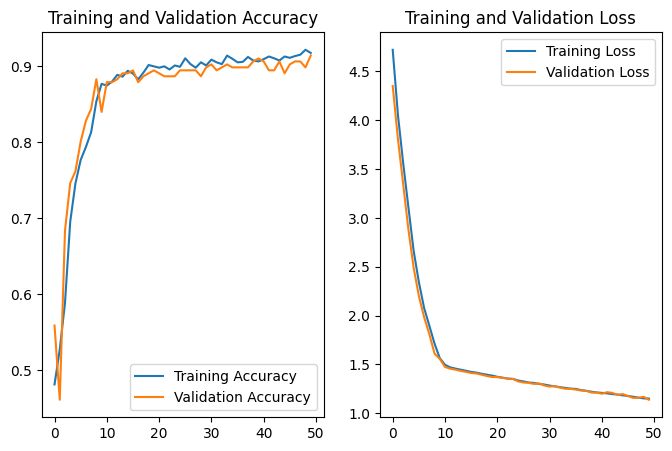

In [44]:
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epoch_nu), acc, label='Training Accuracy')
plt.plot(range(epoch_nu), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epoch_nu), loss, label='Training Loss')
plt.plot(range(epoch_nu), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [97]:
model.save("/content/drive/MyDrive/Transfer files (Clear it frequently)/model/potatoes-model.h5")

In [48]:
import numpy as np

In [74]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


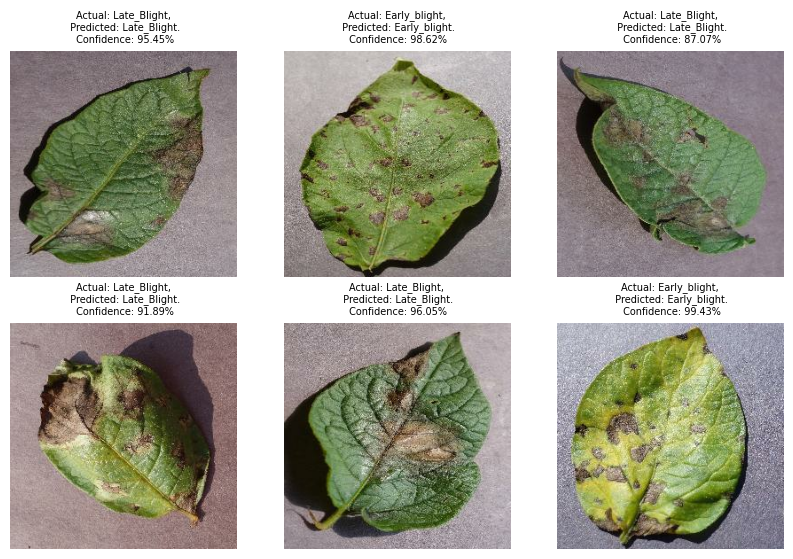

In [96]:
plt.figure(figsize=(10, 10))
for images, labels in test_data.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%", fontsize=7)

        plt.axis("off")

## From web images

1/1 [==============================] - 0s 27ms/step


(-0.5, 767.5, 511.5, -0.5)

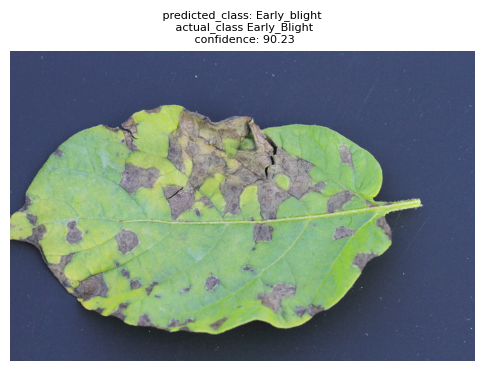

In [95]:
images = plt.imread('/content/potato/potato-early-blight-lesions5.jpeg')
actual = 'Early_Blight'
img_array = tf.keras.preprocessing.image.img_to_array(images)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

predicted_class = class_names[np.argmax(predictions[0])]
confidence = round(100 * (np.max(predictions[0])), 2)

plt.figure(figsize=(6, 6))
plt.imshow(images)
plt.title(f" predicted_class: {predicted_class} \n actual_class {actual}\n confidence: {confidence }", fontsize = 8)
plt.axis("off")

 predicted_class: Late_Blight confidence: 91.21
